In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
import scipy.stats as stats

In [2]:
df = pd.read_csv('googleplaystore.csv')
df1 = df.copy()
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


# Data Cleaning

In [4]:
df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']
print('Number of apps in the dataset : ' , len(df))

Number of apps in the dataset :  9659


#### Convert app sizes to MegaByte,
Remove '+' ','  from 'Number of Installs
,  Remove '$' from Price

In [5]:
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: int(x))


df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))



df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

---

# Exploratory Data Analysis

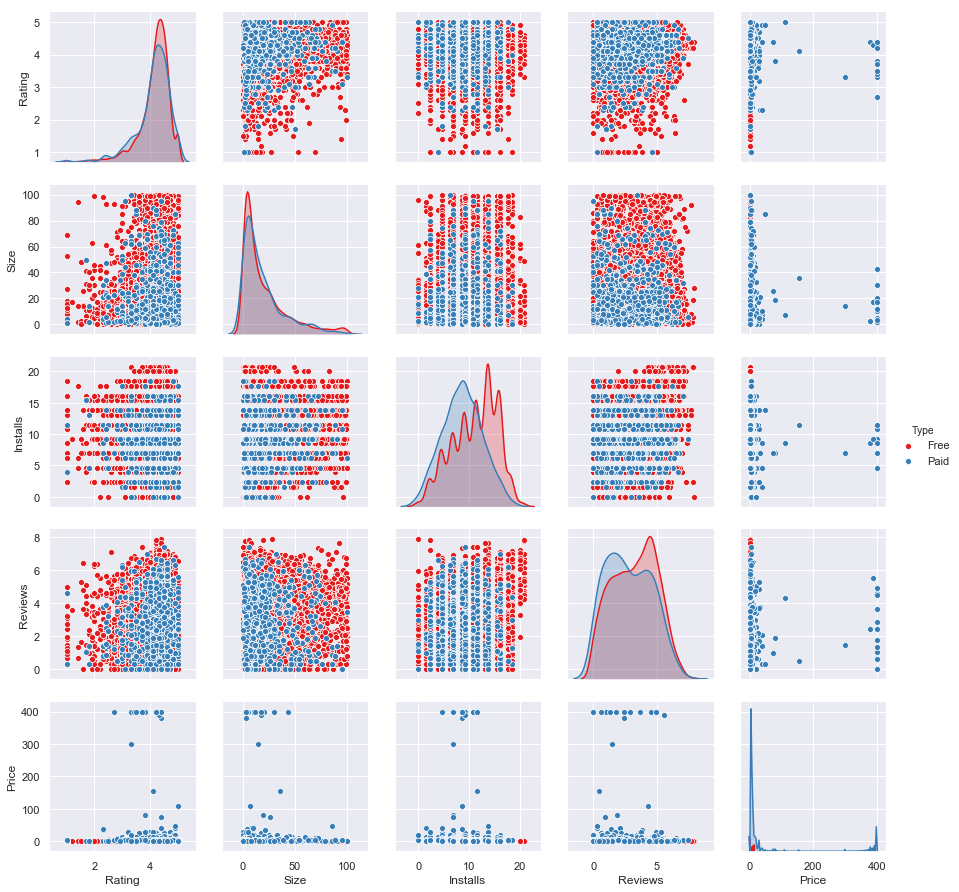

In [6]:
a = df['Rating'].dropna()
b = df['Size'].dropna()
c = df['Installs'][df.Installs!=0].dropna()
d = df['Reviews'][df.Reviews!=0].dropna()
e = df['Type'].dropna()
price = df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(a, b, np.log(c), np.log10(d), e, price)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Type', 'Price']), hue='Type', palette="Set1")

## How Many Apps in each Category?

In [7]:
cat = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = cat.index,
        values = cat.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

### Family and Game apps are the highest.
Tools, Business and Medical apps comes next.

## Average rating of apps in the Dataset

Text(0.5, 1.0, 'Distribution of Rating')

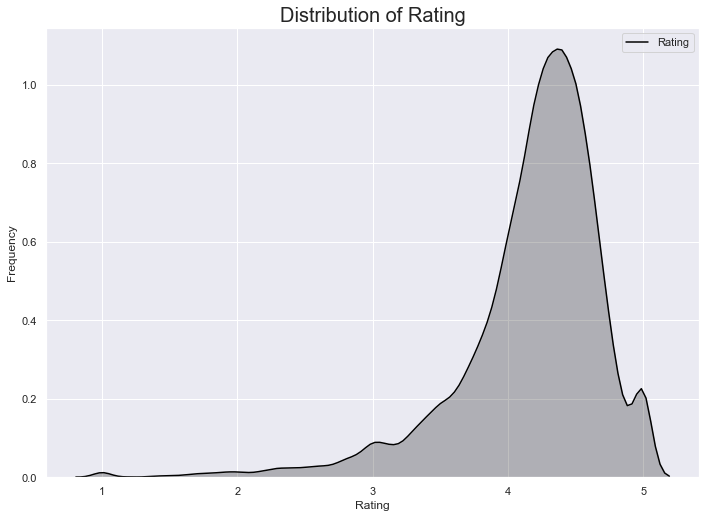

In [8]:
# rating distibution 
rcParams['figure.figsize'] = 11.7,8.27
g = sns.kdeplot(df.Rating, color="black", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

### Average of rating of application in store is around 4 which is very high

## Best performing categories

In [9]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
print('Average rating = ', np.nanmean(list(groups.Rating)))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]

layout = {'title' : 'App Ratings Across Catgories',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'box',
    'name' : category,
    'showlegend':False,
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})

Average rating =  4.170026786973072


### "Health and Fitness" & "Books and Reference" give best app with 50% apps having a rating greater than 4.5

## How To Size our App?

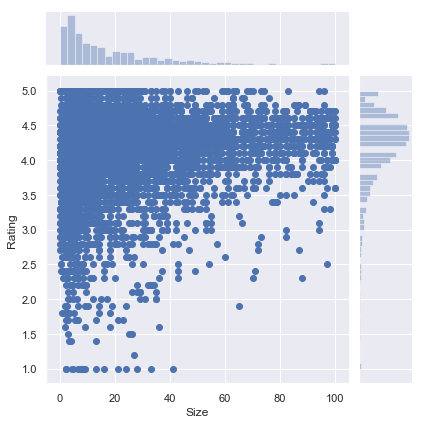

In [10]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'])

### Most top rated apps are sized between 2MB to 40MB 

In [11]:
subset_df = df[df.Size > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    } for category in enumerate(['GAME', 'FAMILY'])]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size in MegaByte'},
         'plot_bgcolor': 'rgb(50,50,50)'}

plotly.offline.iplot({'data': data, 'layout': layout})

### Most big sized apps > 50MB belong to the Game and Family category. although, these apps are highly rated indicating that they are sized like this for a reason.

## How to Price our App?

### top 10 Categories Spent at



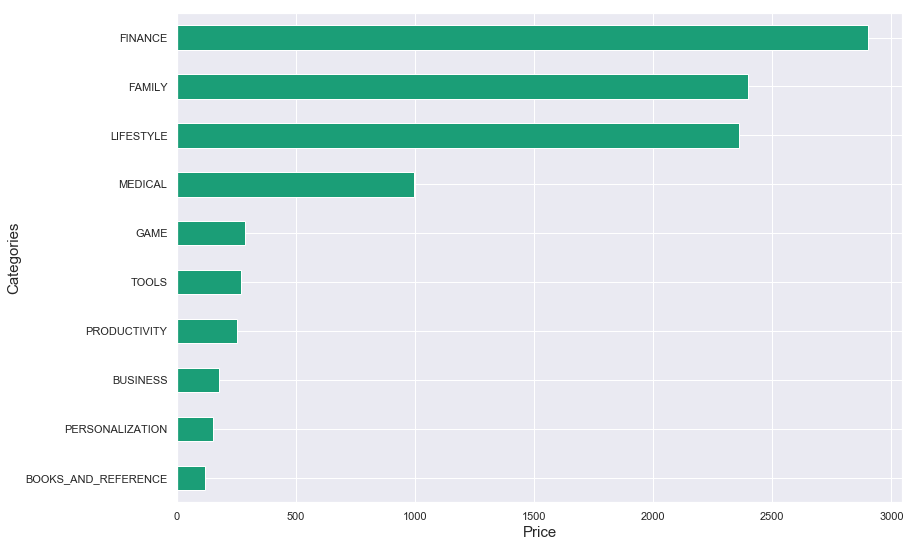

In [12]:
plt.figure(figsize=(13,9))
df.groupby('Category')['Price'].sum().nlargest(10).sort_values().plot(kind='barh',colormap='Dark2')
plt.xlabel('Price', fontsize = 15)
plt.ylabel('Categories',fontsize=15)
plt.show()

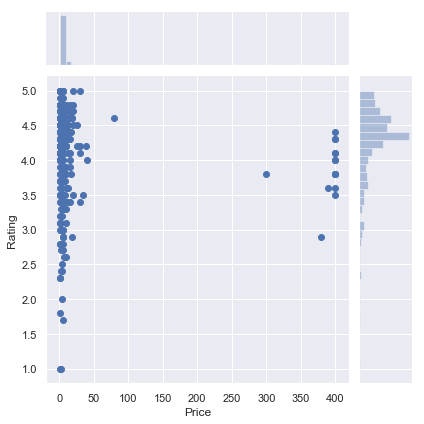

In [13]:
paid_apps = df[df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)

### Most top rated apps are  priced between 1 to 30. There are only a very few apps priced above 20$.

In [14]:
#df[['Category', 'App']][df.Price > 200]

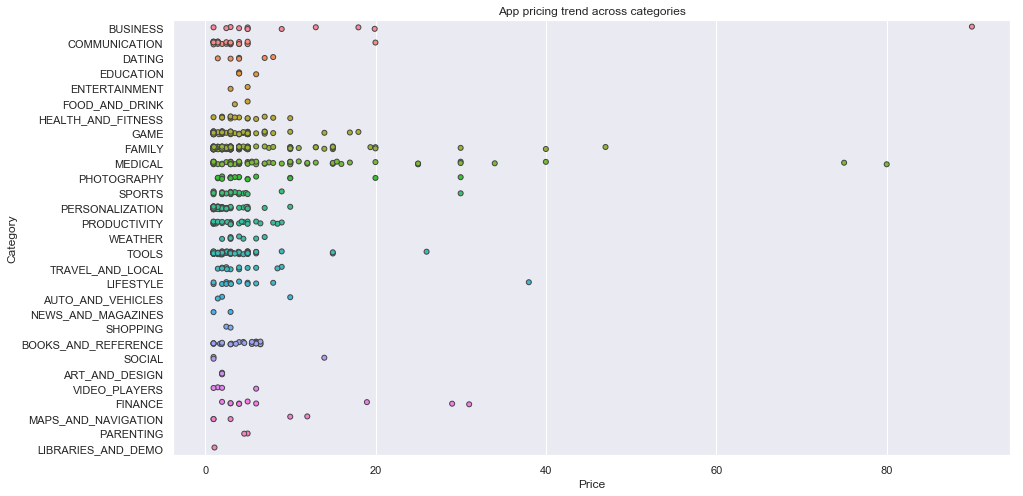

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
subset_df_price = paid_apps[paid_apps.Price<100]
p = sns.stripplot(x="Price", y="Category", data=subset_df_price, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories')

#### Medical and Family apps are the most expensive. Some medical apps extend even upto 80$.

In [16]:
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

In [17]:
temp = df[df.Type == 'Paid']
temp = temp[temp.Size > 5]

data = [{ 
    'x' : temp['Rating'],
    'type':'scatter',
    'y' : temp['Size'],
    'mode' : 'markers',
    'text' : df['Size'],
    } for t in set(temp.Type)]


layout = {'title':"Rating v Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size in MegaByte)'},
         'plot_bgcolor': 'rgb(50,50,50)'}

plotly.offline.iplot({'data': data, 'layout': layout})

### Majority of the paid apps that are highly rated have small sizes.
Users prefer to pay for apps that are smaller

### Exploring Correlations¶

In [18]:
#df.corr()

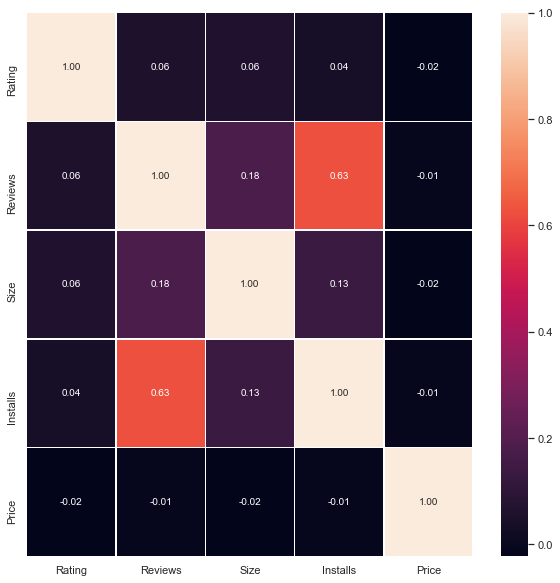

In [19]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(), annot = True, linewidths = .5, fmt = ".2f", ax=ax)

### good positive correlation of 0.63  between the number of reviews and number of downloads

# Sentiment Analysis of User Reviews

In [20]:
reviews_df = pd.read_csv('googleplaystore_user_reviews.csv')
reviews_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [21]:
comb = pd.merge(df, reviews_df, on = "App", how = "inner")
comb = comb.dropna(subset=['Sentiment', 'Translated_Review'])

In [22]:
grouped_sentiment_category_count = comb.groupby(['Category', 'Sentiment']).agg({'App': 'count'}).reset_index()
grouped_sentiment_category_sum = comb.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()

new_df = pd.merge(grouped_sentiment_category_count, grouped_sentiment_category_sum, on=["Category"])

new_df['Sentiment_Normalized'] = new_df.App/new_df.Sentiment_y
new_df = new_df.groupby('Category').filter(lambda x: len(x) ==3)

new_df

trace1 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[::3][6:-5],
    name='Negative',
    marker=dict(color = 'rgb(100, 100, 100)')
)

trace2 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[1::3][6:-5],
    name='Neutral',
    marker=dict(color = 'rgb(250, 243, 44)')
)

trace3 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[2::3][6:-5],
    name='Positive',
    marker=dict(color = 'rgb(0, 255, 255)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Sentiment',
    barmode='stack',
    xaxis = {'tickangle': -45},
    yaxis = {'title': 'Reviews Polarity'}
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot({'data': data, 'layout': layout})

### Health and Fitness apps are the best, with more than 85% positive reviews.
however , many Game and Social apps perform bad leading to 50% positive and 50% negative

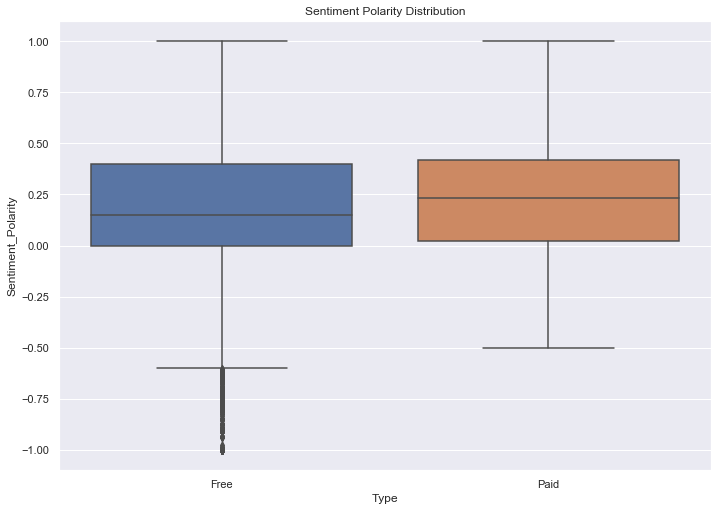

In [23]:
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=comb)
title = ax.set_title('Sentiment Polarity Distribution')

### Free apps receive very harsh comments because of the outliers on the negative Y-axis.

Users are more tolerant while reviewing paid apps - good choice of words.

### WORDCLOUD

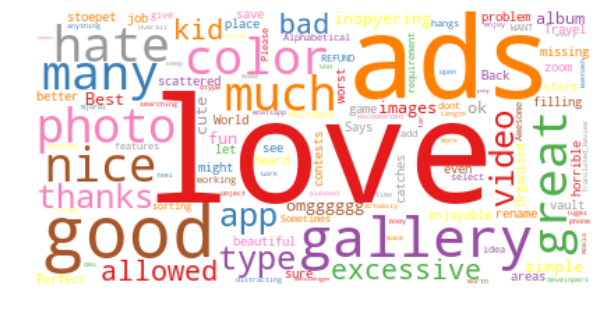

In [24]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=200, colormap="Set1")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

#comb = comb.dropna(subset=['Translated_Review'])
comb['Translated_Review'] = comb['Translated_Review'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
#print(any(comb.Translated_Review.isna()))
comb.Translated_Review = comb.Translated_Review.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
comb.dropna(subset=['Translated_Review'], inplace=True)


free = comb.loc[comb.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

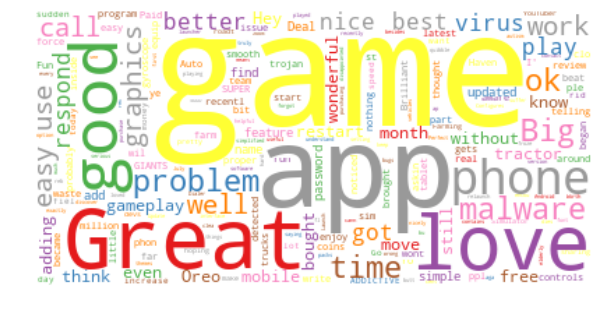

In [25]:
paid = comb.loc[comb.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(paid)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Building

In [26]:
# Convert Reviews To Numeric
df1['Reviews'] = pd.to_numeric(df1.Reviews, errors = 'coerce')

# Sort APP by Reviews
df1 = df1.sort_values(by = ['App', 'Reviews'], ascending = True)

#drops other duplicate entries
df1.drop_duplicates('App',keep='last',inplace=True)

df1.shape

(9660, 13)

In [27]:
#df1.Category.value_counts()

df1 = df1.drop([10472])

#df1.isnull().sum()

In [28]:
#df1.dropna(axis = 0, inplace = True, subset = ['Rating'])
df1['Rating'] = df1['Rating'].fillna(df1['Rating'].median())
df1.shape

(9659, 13)

In [29]:
#Convert non numeric values in App size to NAN
df1['Size'][df1['Size'] == 'Varies with device'] = np.nan

#Replace M with 1 million and k with 1 thousand
df1['Size'] = df1.Size.str.replace('M', 'e6')
df1['Size'] = df1.Size.str.replace('k', 'e3')

#convert column to numeric, dropping non numeric values
df1['Size'] = pd.to_numeric(df1['Size'], errors = 'coerce')

# Price
df1['Price'] = df1['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df1['Price'] = df1['Price'].apply(lambda x: float(x))

In [30]:
df1['Size'] = df1['Size'].fillna(df1['Size'].median())
df1.shape

(9659, 13)

In [31]:
# Installs values encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df1['Installs'] = le.fit_transform(df1['Installs'])

In [32]:
features = ['Category', 'Size' , 'Installs','Rating','Type','Price']
df1 = df1[features].dropna().copy()
df1.shape

(9658, 6)

In [33]:
#convert ratings to high and low categories.
val = dict()
for i in range(0,len(df1['Rating'])):
    if df1['Rating'].iloc[i] >= 3.7:
        val[i] = 'High'
    elif df1['Rating'].iloc[i] >= 2.5:
        val[i] = 'Medium'
    else: val[i] = 'Low'
        
#Add the categorical column to the data 
df1 = df1.assign(val = pd.Series(val).values)

In [34]:
#drop the Ratings column
df1 = df1.drop(['Rating'], axis = 1)

#To encode the Ratings labels for learning
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1['val'] = le.fit_transform(df1['val'])

In [35]:
#Applying One-Hot Encoding to the Categorical Column 'Category' and 'Installs' and 'Type'
df1_enc = pd.get_dummies(df1, columns= ['Category','Installs','Type'])

In [36]:
from sklearn.model_selection import train_test_split

X = df1_enc.drop(['val'], axis = 1)
y = df1_enc['val']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
tst_acc = knn.score(X_test, y_test)
'Accuracy: ' + str(np.round(tst_acc*100, 2)) + '%'

'Accuracy: 88.49%'

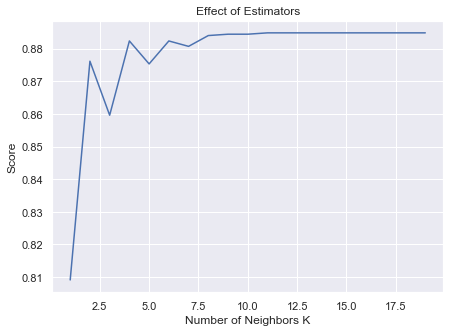

In [38]:
#different numbers of n_neighbors
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)
results = list(zip(n_neighbors,scores))

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=15, max_depth = 10)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest.fit(X_train, y_train)

test_acc = forest.score(X_test, y_test)
'Accuracy: ' + str(np.round(test_acc*100, 2)) + '%'

'Accuracy: 89.32%'

---